# Imports

In [2]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import copy

sys.path.append('/home/nico/VSCodeRepos/SigMA/')
from NoiseRemoval.BulkVelocityClassic import ClassicBV
from miscellaneous.error_sampler import ErrorSampler
from NoiseRemoval.xd_outlier import XDOutlier
from miscellaneous.covariance_trafo_sky2gal import transform_covariance_shper2gal
from SigMA.SigMA import SigMA

# Accuracy Test Case Generation

In [3]:
df_infos = pd.read_csv('simulated_data/simulated_cluster_infos.csv')

In [4]:
class DataGenerator:
    # The contents of this class were mainly written by Sebastian Ratzenböck
    def __init__(self, fname='simulated_data/data_orion_focus.csv'):
        self.data_gaia = pd.read_csv(fname)
        self.df = None
        self.df_noisy = None
        self.labels = None
        self.labels_noisy = None
        self.rv_isnan = None

    def generate_data(self, xyz_mean, uvw_mean, xyz_std, uvw_std, n_samples):
        """Inputs are lists of numpy arrays or lists of integers in the case of n_samples. The lists must have the same length."""
        data_simulated = []
        labels_list = []
        # generate data for each cluster
        cluster_id = 0
        for Xmu_i, Umu_i, Xstd_i, Ustd_i, n_i in zip(xyz_mean, uvw_mean, xyz_std, uvw_std, n_samples):
            X = np.concatenate((Xmu_i, Umu_i))
            std = np.concatenate((Xstd_i, Ustd_i))
            N = max(n_i, 200)
            C = np.diag(std**2)
            cluster_simulated = np.random.multivariate_normal(X, C, N)
            data_simulated.append(cluster_simulated)
            labels_list.append(np.ones(N, dtype=int)*cluster_id)
            cluster_id += 1
        
        data_simulated = np.vstack(data_simulated) # stack all data
        self.labels = np.hstack(labels_list) # stack all labels

        # Simulate a Gaussian cluster in 6D
        cols = ['X', 'Y', 'Z', 'U', 'V', 'W']
        self.df = pd.DataFrame(data_simulated, columns=cols)

        # Sample from the ErrorSampler
        ra, dec, plx, pmra, pmdec, rv = ErrorSampler().cart2spher(self.df[cols].values)
        self.df['ra'] = ra
        self.df['dec'] = dec
        self.df['parallax'] = plx
        self.df['pmra'] = pmra
        self.df['pmdec'] = pmdec
        self.df['radial_velocity'] = rv

        return self.df, self.labels
        
    def add_noise(self, n_samples=50_000, delta_perc=20):
        cols = ['X', 'Y', 'Z', 'U', 'V', 'W']
        cols2match = [
            'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error', 'radial_velocity_error',
            'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
            'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr'
        ]
        # Add bg noise
        ptp_data = self.df[cols].max() - self.df[cols].min()
        ranges = [
            (self.df[col].min() - ptp_data[col] * delta_perc, self.df[col].max() + ptp_data[col] * delta_perc) 
                for col in cols
        ]
        # Create uniform noise
        noise = pd.DataFrame(np.random.uniform(*zip(*ranges), (n_samples, len(cols))), columns=cols)
        ra, dec, plx, pmra, pmdec, rv = ErrorSampler().cart2spher(noise[cols].values)
        noise['ra'] = ra
        noise['dec'] = dec
        noise['parallax'] = plx
        noise['pmra'] = pmra
        noise['pmdec'] = pmdec
        noise['radial_velocity'] = rv
        cols_shere = ['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'radial_velocity']
        # Add noise to data
        self.df_noisy = pd.concat([self.df[cols + cols_shere], noise[cols + cols_shere]], axis=0)
        self.labels_noisy = np.r_[self.labels, np.ones(n_samples) * -1].astype(int)

        # Keep only data within cluster range
        self.df_noisy[cols2match] = self.data_gaia[cols2match].sample(n=self.df_noisy.shape[0], replace=True).values
        self.rv_isnan = self.df_noisy['radial_velocity_error'].isna().values.ravel()
        self.df_noisy.loc[self.rv_isnan, 'radial_velocity_error'] = 1e3
        self.df_noisy.loc[self.rv_isnan, 'radial_velocity'] = 0.0

        err_sampler = ErrorSampler(self.df_noisy)
        err_sampler.build_covariance_matrix()
        # Create sample from errors
        data_new = pd.DataFrame(err_sampler.new_sample(), columns=cols_shere)
        data_new_cart = pd.DataFrame(err_sampler.spher2cart(data_new.values), columns=cols)
        self.df_noisy = pd.concat([data_new, data_new_cart, self.df_noisy[cols2match].reset_index(drop=True)], axis=1)

        # Set radial velocity values to NaNs --> only where the original data had NaNs!!
        self.df_noisy.loc[self.rv_isnan, 'radial_velocity_error'] = np.nan
        self.df_noisy.loc[self.rv_isnan, 'radial_velocity'] = np.nan

        return self.df_noisy, self.labels_noisy, err_sampler

# Velocity Calculation in Perfect Conditions

In [237]:
cluster_idx = [0, 1, 2, 3, 4, 5]  # For more clusters use e.g.: cluster_idx = [0, 2, 4]

xyz_mean = df_infos[['X', 'Y', 'Z']].values[cluster_idx, :]
uvw_mean = df_infos[['U', 'V', 'W']].values[cluster_idx, :]
xyz_std = df_infos[['X_std', 'Y_std', 'Z_std']].values[cluster_idx, :]
uvw_std =  df_infos[['U_std', 'V_std', 'W_std']].values[cluster_idx, :]
n_samples = df_infos[['n_cluster']].values[cluster_idx, :].astype(int)

In [238]:
data_generator = DataGenerator()
data_old, labels_old = data_generator.generate_data(xyz_mean, uvw_mean, xyz_std, uvw_std, n_samples)
data, labels_true, error_sampler = data_generator.add_noise(n_samples=50000)

Negative parallax values encountered, fixing values...


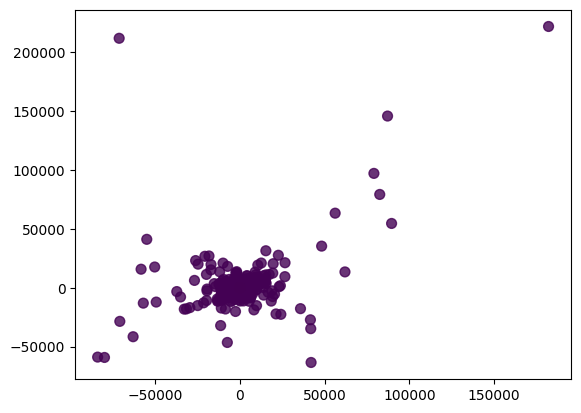

In [168]:
sample_cbve = ClassicBV(data)
sample_cbve_uvw = sample_cbve.estimate_uvw(method='BFGS')
plt.scatter(sample_cbve_uvw[:, 0], sample_cbve_uvw[:, 1], alpha=0.8, s=50, c=labels_true)

In [169]:
# get the true and estimated values of the velocity
approximation = sample_cbve_uvw[labels_true != -1, :]
true = data_old[labels_old != -1][['U', 'V', 'W']]

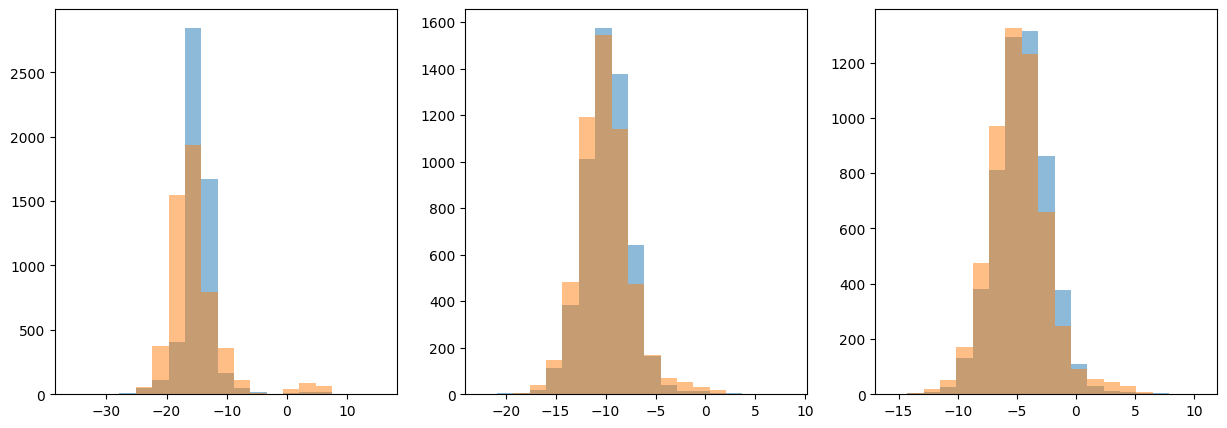

In [135]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    approx_i = approximation[:, i]
    true_i = true.iloc[:, i]

    # make a histogram of the differences
    bins = np.linspace(
        np.min([np.min(approx_i), np.min(true_i)]),
        np.max([np.max(approx_i), np.max(true_i)]),
        20 
    ) 

    ax[i].hist(approx_i, bins=bins, alpha=0.5, label='Esimation')
    ax[i].hist(true_i, bins=bins, alpha=0.5, label='True')

In [176]:
# calculate the error between the approximated and the true values
error_cbve = np.abs(approximation - true)

In [170]:
error_xd = []
for cluster_label in np.unique(labels_true):
    if cluster_label == -1:
        continue

    dense_core = labels_true == cluster_label
    X = data.loc[dense_core, ['U', 'V', 'W']].values
    C_i = error_sampler.C[dense_core, 3:, 3:]
    ra, dec, plx = data.loc[dense_core, ['ra', 'dec', 'parallax']].values.T
    Xerr = transform_covariance_shper2gal(ra, dec, plx, C_i)    

    xd = XDOutlier().fit(X, Xerr)
    mu, cov = xd.min_entropy_component()

    # create a random sample from the estimated parameters
    cluster_size = np.sum(dense_core)
    sample = np.random.multivariate_normal(mu, cov, cluster_size)

    # plot the errors of the sample
    true_i = data_old[labels_old == cluster_label][['U', 'V', 'W']].values
    error = np.abs(sample - true_i)
    error_xd.append(error)
    

In [174]:
error_xd = np.vstack(error_xd)

In [209]:
# get the percentage of values in error_xd being smaller than 10
print(np.mean(error_xd < 10, axis=0))

[0.9671126  0.97733185 0.98327759]


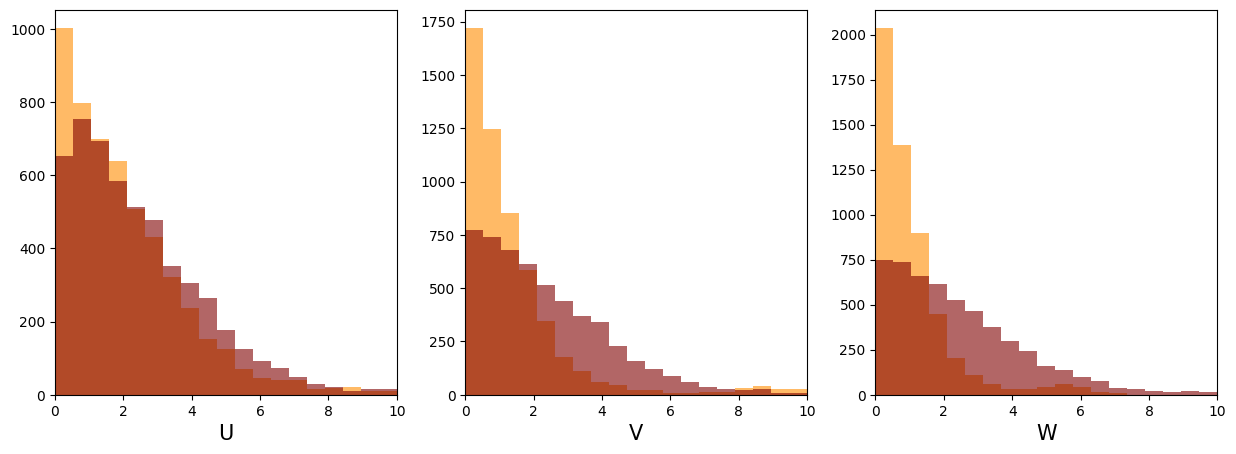

In [212]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    # use the same bins for each dimension
    bins = np.linspace(
        0,
        10,
        20 
    )

    # the histogram are cut after 10, because there are almost no values anymore
    error_i = error_cbve.iloc[:, i]
    ax[i].hist(error_i, bins=bins, alpha=0.6, label='Error', color='darkorange')
    ax[i].set_xlim(0, 10)

    error_i = error_xd[:, i]
    ax[i].hist(error_i, bins=bins, alpha=0.6, label='Error', color='maroon')
    ax[i].set_xlim(0, 10)

    if i == 0:
        ax[i].set_xlabel('U', fontsize=15)
    elif i == 1:
        ax[i].set_xlabel('V', fontsize=15)
    else:
        ax[i].set_xlabel('W', fontsize=15)

# Velocity Determination with Noise

In [17]:
cluster_idx = [0]  # For more clusters use e.g.: cluster_idx = [0, 2, 4]

xyz_mean = df_infos[['X', 'Y', 'Z']].values[cluster_idx, :]
uvw_mean = df_infos[['U', 'V', 'W']].values[cluster_idx, :]
xyz_std = df_infos[['X_std', 'Y_std', 'Z_std']].values[cluster_idx, :]
uvw_std =  df_infos[['U_std', 'V_std', 'W_std']].values[cluster_idx, :]
n_samples = df_infos[['n_cluster']].values[cluster_idx, :].astype(int)

In [21]:
data_generator = DataGenerator()
data_old, labels_old = data_generator.generate_data(xyz_mean, uvw_mean, xyz_std, uvw_std, n_samples)
data, labels_true, error_sampler = data_generator.add_noise(n_samples=n_samples[0][0])

Negative parallax values encountered, fixing values...


In [22]:
sample_cbve = ClassicBV(data)
sample_cbve_uvw = sample_cbve.estimate_uvw(method='BFGS')
# plt.scatter(sample_cbve_uvw[:, 0], sample_cbve_uvw[:, 1], alpha=0.8, s=50, c=labels_true)

In [23]:
# get the true and estimated values of the velocity
approximation = sample_cbve_uvw
true = data[['U', 'V', 'W']]

In [24]:
error_cbve = np.abs(approximation - true)

In [27]:
X = data.loc[:, ['U', 'V', 'W']].values
C_i = error_sampler.C[:, 3:, 3:]
ra, dec, plx = data.loc[:, ['ra', 'dec', 'parallax']].values.T
Xerr = transform_covariance_shper2gal(ra, dec, plx, C_i)

xd = XDOutlier().fit(X, Xerr)
mu, cov = xd.min_entropy_component()

# create a random sample from the estimated parameters
sample = np.random.multivariate_normal(mu, cov, n_samples[0][0]*2)

error_xd = np.abs(sample - true)

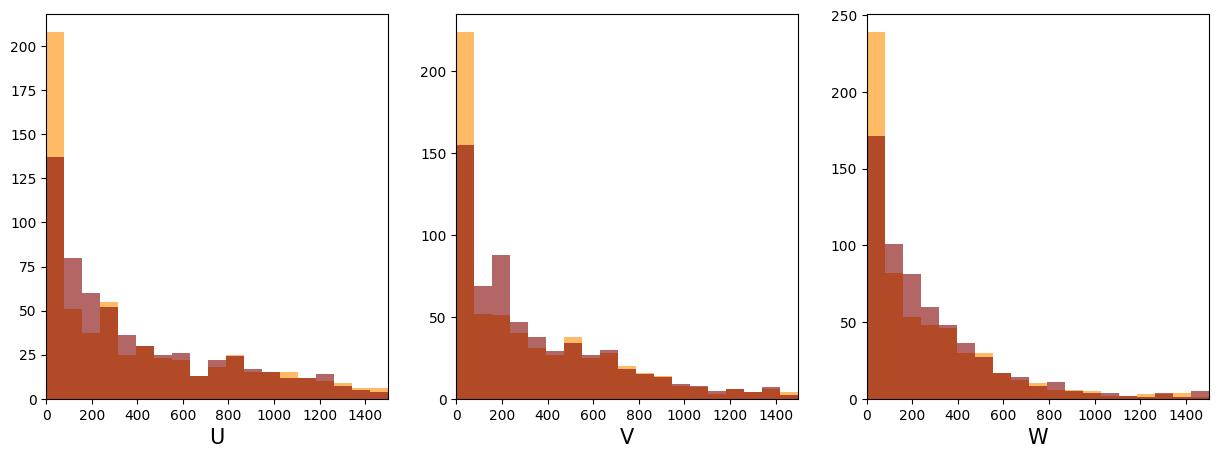

In [32]:
# create a histogram
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    bins = np.linspace(0, 1500, 20)

    # the histogram are cut after 10, because there are almost no values anymore
    ax[i].hist(error_cbve.iloc[:, i], bins=bins, alpha=0.6, label='Error', color='darkorange')
    ax[i].hist(error_xd.iloc[:, i], bins=bins, alpha=0.6, label='Error', color='maroon')

    ax[i].set_xlim(0, 1500)

    if i == 0:
        ax[i].set_xlabel('U', fontsize=15)
    elif i == 1:
        ax[i].set_xlabel('V', fontsize=15)
    else:
        ax[i].set_xlabel('W', fontsize=15)